<a href="https://colab.research.google.com/github/nikhilv7/MIMO-gao/blob/master/mimogao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys
np.set_printoptions(threshold=100000)
import random
import os

#Initialisation
* h_gen is the Function for generating  Channel( Random Initialisation)

In [ ]:
random.seed(21)

x = list(range(0, 20))            #
antennaCount=64  
antennaList=np.arange(0,antennaCount)
antennaList=antennaList.reshape(antennaCount,1)
pi = np.pi
trainingCount = 90000
train_h=np.zeros([trainingCount,antennaCount],dtype=complex)
validationCount = 14700
val_h=np.zeros([validationCount,antennaCount],dtype=complex)
testCount = 28000
test_h=np.zeros([testCount,antennaCount],dtype=complex)
tot_set = trainingCount + validationCount + testCount

def h_gen():
  propGain = (np.random.normal(0, 1, 8) + 1j * np.random.normal(0, 1, 8)) / np.sqrt(2)                  #Propagation Gain for Each Multipath Component (Unit Power) 
  phi = np.multiply((2 * pi / 20), random.choices(x, k=8))                                              #Randomly choosing Angle of arrival of different Multipath Components
  phi=phi.reshape([1,8])
  aphi=(1/np.sqrt(8))*np.exp((-1j*2*pi*np.sin(phi))*antennaList)                                        #Response Vector(Function of arrival angles) 
  channel=np.sum(aphi*propGain,axis=1)
  return channel
print(h_gen().shape)


(64,)


Generating Channels for Training, Validation and Testing

In [ ]:
for i in range(trainingCount):
  train_h[i,:]=h_gen()
for i in range(testCount):
  test_h[i,:]=h_gen()
for i in range(validationCount):
    val_h[i,:]=h_gen()


*   The Neural Network Cannot Process complex data as such.

*   So the 64 units long Complex data is divided into 64 real and 64 imaginary part vectors and is concateneated to get a 128 unit long Real Vector




In [ ]:
train_hvector = np.concatenate((np.real(train_h), np.imag(train_h)), axis=1)
val_hvector = np.concatenate((np.real(val_h), np.imag(val_h)), axis=1)
test_hvector = np.concatenate((np.real(test_h), np.imag(test_h)), axis=1)

print(train_h.shape, val_h.shape, test_h.shape, train_hvector.shape, val_hvector.shape, test_hvector.shape)

(90000, 64) (14700, 64) (28000, 64) (90000, 128) (14700, 128) (28000, 128)


ADC model


1) Preparing Training Data

In [ ]:
from collections import Counter
nn=0.5                                                                          #ratio of high Res antennas to Total no antennas
HighResCount =int(nn*antennaCount)   
LowResCount=antennaCount-HighResCount                                                                 
a=[0.6366,0.8825,0.96546,0.990503,0.997501]
alpha=a[0]
snrdb=[0,5,10,15,20,25,30]
snrLinear=np.power(10,np.divide(snrdb,10))

powerTrain=random.choices(snrLinear,k=trainingCount)
powerTrain=np.asarray(power).reshape([trainingCount,1])                         #Converting and reshaping the list to Numpy array

Covariance Matrix for Quantisation Noise

In [ ]:
def qNoiseGen(h,power):
    SampleCount=h.shape[0]
    hLowRes = h[:,HighResCount:]
    Rq=alpha*(1-alpha)*(1+power*(abs(hLowRes)**2))                              #Covariance Matrix
    QuantNoise = (np.random.normal(0, Rq)+ 
                  1j * np.random.normal(0, Rq)) / np.sqrt(2)
    return QuantNoise            

In [ ]:
noise1 = (np.random.normal(0,np.ones([ trainingCount,antennaCount])) +
      1j * np.random.normal(0, np.ones([ trainingCount,antennaCount]))) / np.sqrt(2)
y=np.sqrt(power)*train_h+noise1                                                 # System Model
y_highRes=y[:,:HighResCount]
quantNoisetrain=qNoiseGen(train_h,powerTrain)
y_lowRes=alpha*y[:,HighResCount:]+quantNoisetrain

#Training Set for DI-DNN
train_recieved=np.concatenate((y_highRes,y_lowRes),axis=1)                      #Recieved Values at the output of the RF chain
train_recieved=train_recieved/np.sqrt(power)                                    #Output of Least Square Estimation
train_recievedVector = np.concatenate((np.real(train_recieved), np.imag(train_recieved)), axis=1)             #Unrolling real and imag Axis

print(y.shape,y_highRes.shape,train_recieved.shape,train_recievedVector.shape)

(90000, 64) (90000, 32) (90000, 64) (90000, 128)


2) Preparing Test data for different SNR

In [ ]:
testCountperSNR=4000
noise2 = (np.random.normal(0, np.ones([testCount,antennaCount])) + 
          1j * np.random.normal(0,np.ones([testCount,antennaCount]))) / np.sqrt(2)
y_test=np.zeros([antennaCount,testCount],dtype=complex)
powerTest=np.repeat(snrLinear,testCountperSNR).reshape([testCount,1])           #Repeating Each SNR 4000 times to generate 4000 test samples for each SNR value

y_test=np.sqrt(powerTest)*test_h+noise2
y_highResTest=y_test[:,:HighResCount]
quantNoisetest= qNoiseGen(test_h,powerTest)
y_lowResTest=alpha*y_test[:,HighResCount:]+quantNoisetest

test_recieved=np.concatenate((y_highResTest,y_lowResTest),axis=1)
test_recieved/=np.sqrt(powerTest)
test_recievedVector=np.concatenate((np.real(test_recieved), np.imag(test_recieved)), axis=1)
print(y_test.shape,test_recievedVector.shape)

(28000, 64) (28000, 128)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
checkpoint_path='/content/gdrive/My Drive/Colab_Notebooks/cp'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Model for DI-DNN

In [ ]:
def myModel():
  model = keras.models.Sequential([
      keras.layers.Dense(160, activation='relu',input_shape=(128,)),
      keras.layers.Dense(200, activation='relu'),
      #keras.layers.Dense(400, activation=tf.nn.relu),
      keras.layers.Dense(160, activation='relu'),
      keras.layers.Dense(128, activation='tanh'),
  ])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mse',metrics='accuracy')
  return model

model =myModel()
#model=keras.models.load_model('/content/drive/My Drive/Research/Models/mimogao')
#model.load_weights(checkpoint_path)
log=model.fit(train_recievedVector,train_hvector/3,epochs=100,verbose=1,batch_size=128)
model.summary()

Epoch 1/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0463 - accuracy: 0.0482
Epoch 2/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0143 - accuracy: 0.2752
Epoch 3/100
704/704 [==============================] - 3s 5ms/step - loss: 0.0093 - accuracy: 0.3672
Epoch 4/100
704/704 [==============================] - 3s 5ms/step - loss: 0.0088 - accuracy: 0.3815
Epoch 5/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0085 - accuracy: 0.3916
Epoch 6/100
704/704 [==============================] - 3s 5ms/step - loss: 0.0084 - accuracy: 0.3971
Epoch 7/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0083 - accuracy: 0.4013
Epoch 8/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0083 - accuracy: 0.4010
Epoch 9/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0082 - accuracy: 0.4027
Epoch 10/100
704/704 [==============================] - 3s 4ms/step - loss: 0.0082 - accura

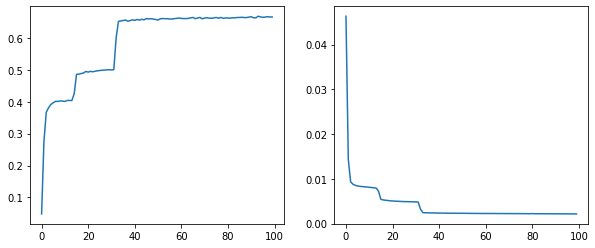

In [ ]:
import matplotlib.pyplot as plt

fig,axes= plt.subplots(1,2,figsize=(10,4))
axes[0].plot(log.history['accuracy'])
axes[1].plot(log.history['loss'])

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model_name = "mimogao"
model_dir = "/content/gdrive/My Drive/Research/Models/"
dir = os.path.join(model_dir, model_name)
model.save(dir)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Research/Models/mimogao/assets


In [ ]:
model=keras.models.load_model(dir)

Finding Mean Square Corresponding to each SNR value

In [ ]:
for w in range(len(snrLinear)):
  loss,acc=model.evaluate(test_recievedVector[w*testCountperSNR:(w+1)*testCountperSNR,:],test_hvector[w*testCountperSNR:(w+1)*testCountperSNR,:]/3)


125/125 [==============================] - 0s 1ms/step - loss: 8.1820e-04 - accuracy: 0.7538


In [ ]:
h_predict=model.predict(test_recievedVector)
h_retain=h_predict[:,:antennaCount]+1j*h_predict[:,antennaCount:]
diff=(test_h-h_retain)
normsq_test=np.square(np.linalg.norm(test_h,axis=1))
normsq_diff=np.square(np.linalg.norm(diff,axis=1))
error=normsq_diff/normsq_test
nmse=np.zeros(len(snrLinear),)
for w in range(len(snrLinear)):
  nmse[w]= (1/testCountperSNR) * np.sum(error[w*testCountperSNR:(w+1)*testCountperSNR])

print(nmse)
#print(norm_test.shape,norm_diff.shape)
#print(h_predict.shape,h_retain.shape,diff.shape)
#print(diff)
#h_predict-
#for w in range(len(snrLinear)):
 # loss,acc=h_predict(test_recievedVector[:,w*testCountperSNR:(w+1)*testCountperSNR].T,test_hvector[:,w*testCountperSNR:(w+1)*testCountperSNR].T/3,)



[0.53161828 0.48680688 0.46199279 0.45204923 0.44873686 0.44794582
 0.4476189 ]


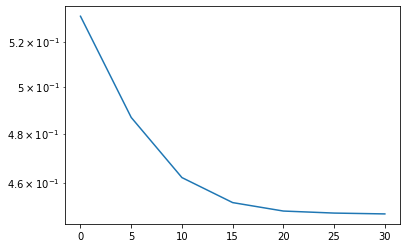

In [ ]:
import matplotlib.pyplot as plt
plt.semilogy(snrdb,nmse)

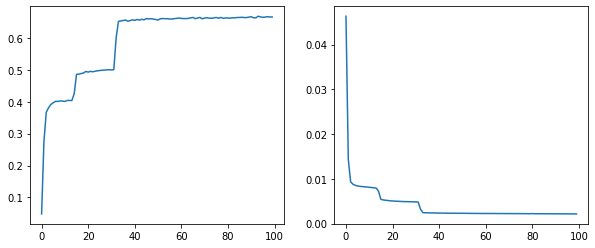

SIP-DNN: 
Uses the information obtained from the set of High resolution ADCS to train the Network.